In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [2]:
def proportions_from_distribution(table, label, sample_size):
    proportions = np.random.multinomial(sample_size, table.column(label))/sample_size
    return table.with_column('Random Sample', proportions)

### Multiple Categories ###
We have developed a way of assessing models about chance processes that generate data in two categories. The method extends to models involving data in multiple categories. The process of assessment is the same as before, the only difference being that we have to come up with a new statistic to simulate.

Let's do this in an example that addresses the same kind of question that was raised in the case of Robert Swain's jury panel. This time, the data are more recent.

### Jury Selection in Alameda County ###

In 2010, the American Civil Liberties Union (ACLU) of Northern California presented a [report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf "ACLU_NC report") on jury selection in Alameda County, California. The report concluded that certain ethnic groups are underrepresented among jury panelists in Alameda County, and suggested some reforms of the process by which eligible jurors are assigned to panels. In this section, we will perform our own analysis of the data and examine some questions that arise as a result.

Some details about jury panels and juries will be helpful in interpreting the results of our analysis.

### Jury Panels ###

A jury panel is a group of people chosen to be prospective jurors; the final trial jury is selected from among them. Jury panels can consist of a few dozen people or several thousand, depending on the trial. By law, a jury panel is supposed to be representative of the community in which the trial is taking place. Section 197 of California's Code of Civil Procedure says, "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

The final jury is selected from the panel by deliberate inclusion or exclusion. The law allows potential jurors to be excused for medical reasons; lawyers on both sides may strike a certain number of potential jurors from the list in what are called "peremptory challenges"; the trial judge might make a selection based on questionnaires filled out by the panel; and so on. But the initial panel is supposed to resemble a random sample of the population of eligible jurors.

### Composition of Panels in Alameda County ###

The focus of the study by the ACLU of Northern California was the ethnic composition of jury panels in Alameda County. The ACLU compiled data on the ethnic composition of the jury panels in 11 felony trials in Alameda County in the years 2009 and 2010. In those panels, the total number of people who reported for jury service was 1,453. The ACLU gathered demographic data on all of these prosepctive jurors, and compared those data with the composition of all eligible jurors in the county. 

The data are tabulated below in a table called ``jury``. For each ethnicity, the first value is the proportion of all eligible juror candidates of that ethnicity. The second value is the proportion of people of that ethnicity among those who appeared for the process of selection into the jury.

In [2]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


Some ethnicities are overrepresented and some are underrepresented on the jury panels in the study. A bar chart is helpful for visualizing the differences.

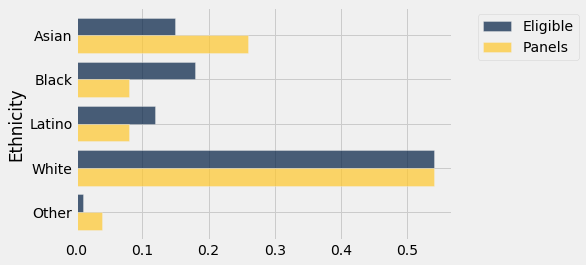

In [3]:
jury.barh('Ethnicity')

### Comparison with Panels Selected at Random ###
What if we select a random sample of 1,453 people from the population of eligible jurors? Will the distribution of their ethnicities look like the distribution of the panels above?

We can answer these questions by using `sample_proportions` and augmenting the `jury` table with a column of the proportions in our sample.

**Technical note.** Random samples of prospective jurors would be selected without replacement. However, when the size of a sample is small relative to the size of the population, sampling without replacement resembles sampling with replacement; the proportions in the population don't change much between draws. The population of eligible jurors in Alameda County is over a million, and compared to that, a sample size of about 1500 is quite small. We will therefore sample with replacement.

In the cell below, we sample at random 1453 times from the distribution of eligible jurors, and display the distribution of the random sample along with the distributions of the eligible jurors and the panel in the data.

In [4]:
eligible_population = jury.column('Eligible')
sample_distribution = sample_proportions(1453, eligible_population)
panels_and_sample = jury.with_column('Random Sample', sample_distribution)
panels_and_sample

Ethnicity,Eligible,Panels,Random Sample
Asian,0.15,0.26,0.13214
Black,0.18,0.08,0.168617
Latino,0.12,0.08,0.115623
White,0.54,0.54,0.573985
Other,0.01,0.04,0.00963524


The distribution of the random sample is quite close to the distribution of the eligible population, unlike the distribution of the panels.

As always, it helps to visualize.

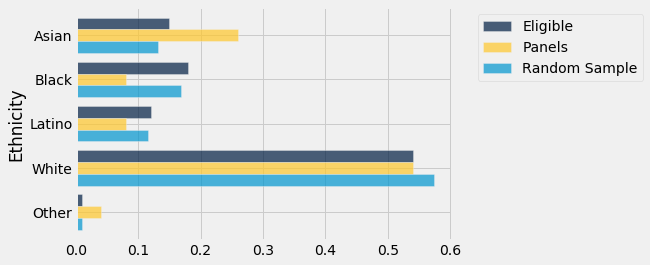

In [5]:
panels_and_sample.barh('Ethnicity')

The bar chart shows that the distribution of the random sample resembles the eligible population but the distribution of the panels does not.

To assess whether this observation is particular to one random sample or more general, we can  simulate multiple panels under the model of random selection and see what the simulations predict. But we won't be able to look at thousands of bar charts like the one above. We need a statistic that will help us assess whether or not the model or random selection is supported by the data.

### A New Statistic: The Distance between Two Distributions ###
We know how to measure how different two numbers are – if the numbers are $x$ and $y$, the distance between them is $\vert x-y \vert$. Now we have to quantify the distance between two distributions. For example, we have to measure the distance between the blue and gold distributions below.

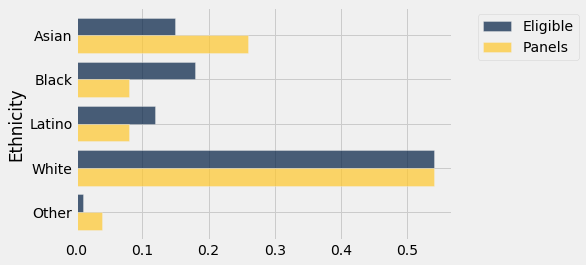

In [6]:
jury.barh('Ethnicity')

For this we will compute a quantity called the *total variation distance* between two distributions. The calculation is as an extension of the calculation of the distance between two numbers.

To compute the total variation distance, we first take the difference between the two proportions in each category.

In [7]:
# Augment the table with a column of differences between proportions

jury_with_diffs = jury.with_column(
    'Difference', jury.column('Panels') - jury.column('Eligible')
)
jury_with_diffs

Ethnicity,Eligible,Panels,Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.1
Latino,0.12,0.08,-0.04
White,0.54,0.54,0
Other,0.01,0.04,0.03


Take a look at the column `Difference` and notice that the sum of its entries is 0: the positive entries add up to 0.14, exactly canceling the total of the negative entries which is -0.14. 

This is numerical evidence of the fact that in the bar chart, the gold bars exceed the blue bars by exactly as much as the blue bars exceed the gold. The proportions in each of the two columns ``Panels`` and ``Eligible`` add up to 1, and so the give-and-take between their entries must add up to 0. 

To avoid the cancellation, we drop the negative signs and then add all the entries. But this gives us two times the total of the positive entries (equivalently, two times the total of the negative entries, with the sign removed). So we divide the sum by 2.

In [8]:
jury_with_diffs = jury_with_diffs.with_column(
    'Absolute Difference', np.abs(jury_with_diffs.column('Difference'))
)

jury_with_diffs

Ethnicity,Eligible,Panels,Difference,Absolute Difference
Asian,0.15,0.26,0.11,0.11
Black,0.18,0.08,-0.1,0.1
Latino,0.12,0.08,-0.04,0.04
White,0.54,0.54,0,0
Other,0.01,0.04,0.03,0.03


In [9]:
jury_with_diffs.column('Absolute Difference').sum() / 2

0.14

This quantity 0.14 is the *total variation distance* (TVD) between the distribution of ethnicities in the eligible juror population and the distribution in the panels.

We could have obtained the same result by just adding the positive differences. But our method of including all the absolute differences eliminates the need to keep track of which differences are positive and which are not.

### Simulating One Value of the Statistic ###
We will use the total variation distance between distributions as the statistic to simulate. It will help us decide whether the model of random selection is good, because large values of the distance will be evidence against the model.

Keep in mind that **the observed value of our statistic is 0.14**, calculated above.

Since we are going to be computing total variation distance repeatedly, we will write a function to compute it.

The function `total_variation_distance` returns the TVD between distributions in two arrays.

In [10]:
def total_variation_distance(distribution_1, distribution_2):
    return sum(np.abs(distribution_1 - distribution_2)) / 2

This function will help us calculate our statistic in each repetition of the simulation. But first, let's check that it gives the right answer when we use it to compute the distance between the blue (eligible) and gold (panels) distributions above.

In [11]:
total_variation_distance(jury.column('Panels'), jury.column('Eligible'))

0.14

This agrees with the value that we computed directly without using the function.

In the cell below we use the function to compute the TVD between the distributions of the eligible jurors and one random sample. This is the code for simulating one value of our statistic. Recall that `eligible_population` is the array containing the distribution of the eligible jurors.

In [12]:
sample_distribution = sample_proportions(1453, eligible_population)
total_variation_distance(sample_distribution, eligible_population)

0.0202202339986235

Notice that the distance is quite a bit smaller than 0.14, the distance between the distribution of the panels and the eligible jurors.

We are now ready to run a simulation to assess the model of random selection.

### Predicting the Statistic Under the Model of Random Selection ###
The total variation distance between the distributions of the random sample and the eligible jurors is the statistic that we are using to measure the distance between the two distributions. By repeating the process of sampling, we can see how much the statistic varies across different random samples. 

The code below simulates the statistic based on a large number of replications of the random sampling process, following our usual sequence of steps for simulation. We first define a function that returns one simulated value of the total variation distance under the hypothesis of random selection. Then we use our function in a `for` loop to create an array `tvds` consisting of 5,000 such distances.

In [13]:
# Simulate one simulated value of 
# the total variation distance between
# the distribution of a sample selected at random
# and the distribution of the eligible population

def one_simulated_tvd():
    sample_distribution = sample_proportions(1453, eligible_population)
    return total_variation_distance(sample_distribution, eligible_population)   

In [14]:
tvds = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    tvds = np.append(tvds, one_simulated_tvd())

The empirical histogram of the simulated distances shows that drawing 1453 jurors at random from the pool of eligible candidates results in a distribution that rarely deviates from the eligible jurors' race distribution by more than about 0.05.

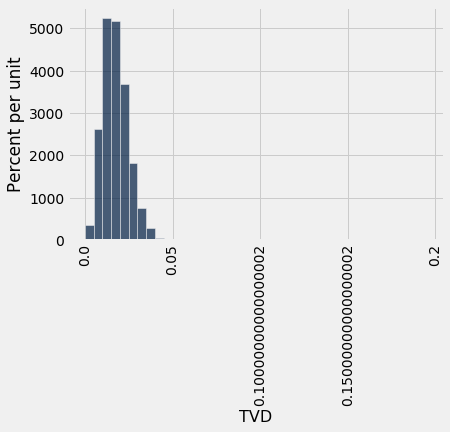

In [15]:
Table().with_column('TVD', tvds).hist(bins=np.arange(0, 0.2, 0.005))

### Assessing the Model of Random Selection ###

The panels in the study, however, were not quite so similar to the eligible population. The total variation distance between the panels and the population was 0.14, which is far out in the tail of the histogram above. It does not look at all like a typical distance between a random sample and the eligible population.

The data in the panels is not consistent with the predicted values of the statistic based on the model of random selection. So our analysis supports the ACLU's calculation that the panels were not representative of the distribution provided for the eligible jurors. 

### Some Possible Explanations for the Differences ###
As with most such analyses, however, our analysis does not say *why* the distributions are different or what the difference might imply.

The ACLU report discusses several possible reasons for the discrepancies. For example, some minority groups were underrepresented on the records of voter registration and of the Department of Motor Vehicles, the two main sources from which jurors are selected. At the time of the study, the county did not have an effective process for following up on prospective jurors who had been called but had failed to appear. The ACLU listed several other reasons as well. Whatever the reasons, it seems clear that the composition of the jury panels was different from what we would have expected in a random sample from the distribution in the `Eligible` column.

### Questions about the Data ###
We have developed a powerful technique that helps decide whether one distribution looks like a random sample from another. But data science is about more than techniques. In particular, data science always involves a thoughtful examination of how the data were gathered.

**Eligible Jurors.** First, it is important to remember that not everyone is eligible to serve on a jury. On its [website](http://www.alameda.courts.ca.gov/pages.aspx/jury-duty-overview), the Superior Court of Alameda County says, "You may be called to serve if you are 18 years old, a U.S. citizen and a resident of the county or district where summoned. You must be able to understand English, and be physically and mentally capable of serving. In addition, you must not have served as any kind of juror in the past 12 months, nor have been convicted of a felony."

The Census doesn't maintain records of the populations in all these categories. Thus the ACLU had to obtain the demographics of eligible jurors in some other way. Here is their own description of the process they followed and some flaws that it might contain.

"For the purpose of determining the demographics of Alameda County’s jury eligible population, we used a declaration that was prepared for the Alameda County trial of People v. Stuart Alexander in 2002. In the declaration, Professor Weeks, a demographer at San Diego State University, estimated the jury eligible population for Alameda County, using the 2000 Census data. To arrive at this estimate, Professor Weeks took into account the number of people who are not eligible for jury services because they do not speak English, are not citizens, are under 18, or have a felony conviction. Thus, his estimate should be an accurate assessment of who is actually eligible for jury service in Alameda County, much more so than simply reviewing the Census report of the race and ethnicity of all people living in Alameda County. It should be noted, however, that the Census data on which Professor Weeks relied is now ten years old and the demographics of the county may have changed by two or three percent in some categories."

Thus the distribution of ethnicities of eligible jurors used in the analysis is itself an estimate and might be somewhat out of date.

**Panels.** In addition, panels aren't selected from the entire eligible population. The Superior Court of Alameda County says, "The objective of the court is to provide an accurate cross-section of the county's population. The names of jurors are selected at random from everyone who is a registered voter and/or has a driver's license or identification card issued by the Department of Motor Vehicles."

All of this raises complex questions about how to accurately estimate the ethnic composition of eligible jurors in Alameda County. 

It is not clear exactly how the 1453 panelists were classified into the different ethnic categories (the ACLU report says that "attorneys ... cooperated in collecting jury pool data"). There are serious social, cultural, and political factors that affect who gets classified or self-classifies into each ethnic category. We also don't know whether the definitions of those categories in the panels are the same as those used by Professor Weeks who in turn used Census categories in his estimation process. Thus there are also questions about the correspondence between the two distributions being compared.

Thus, while we have a clear conclusion about the data in our table – the panels do not look like a random sample from the distribution provided for eligible jurors – questions about the nature of the data prevent us from concluding anything broader.